# Temperature Prediction (Time Series Forecasting)

## Goals:
- By using **SARIMAX**, we will predict the average temperature of each month from 2021 January to 2021 August.
- Procedure:
    - Group the dataset by each month and obtain the average temperature of each month.
    - By using the rolling statistics and adfuller test check whether the dataset is stationary or not
        - If not, make it stationary by subtracting the value with a dataset that is shifted by 12.
    - By using a stationary dataset, plot ACF and PACF graphs to determine the value of p and q.
    - Once, p,d,q values are determined, build a SARIMAX model
    - Test the model with real average temperature values

### **What is SARIMAX?**
- Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors
- This model includes seasonal effects and exogenous factors with the autoregressive and moving average component.

### **Why this method?**
- As there are seasonal cycles, it is better to predict the temperature with SARIMAX rather than normal ARIMA.
    - ARIMA doesn't work well with seasonality.
- Also this model considers the exogenous variables.
    


# Import Modules & Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from math import sqrt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.tseries.offsets import DateOffset

In [2]:
def adfuller_test(data):
    result = adfuller(data,autolag="AIC")
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data Preprocessing

In [4]:
wdata = pd.read_csv("cleaned_wdata.csv")

In [5]:
# Group by Month
wdata = pd.DataFrame(wdata.groupby(by=['Year','Month']).mean()['Temperature(F)']).reset_index()

In [6]:
wdata

,Year,Month,Temperature(F)
0,2010,1,26.243066
1,2010,2,28.719726
2,2010,3,39.739726
3,2010,4,48.830303
4,2010,5,56.096591
...,...,...,...
127,2020,8,71.384170
128,2020,9,63.125677
129,2020,10,49.844045
130,2020,11,43.235975


In [7]:
# Create Date Column with Year & Month
wdata['dateInt']=wdata['Year'].astype(str) + wdata['Month'].astype(str).str.zfill(2) 
wdata['Date'] = pd.to_datetime(wdata['dateInt'], format='%Y%m')
wdata = wdata[['Date','Temperature(F)']]

# Checking Stationality

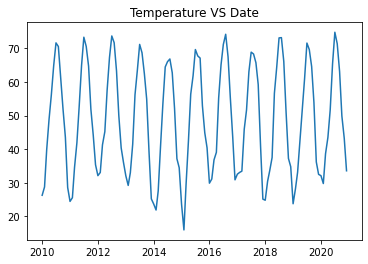

In [8]:
# Plot Temperature VS Date Graph
plt.title("Temperature VS Date")
plt.plot(wdata['Date'],wdata['Temperature(F)'])

/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

Text(0.5, 1.0, 'Rolling Mean, Rolling Std')

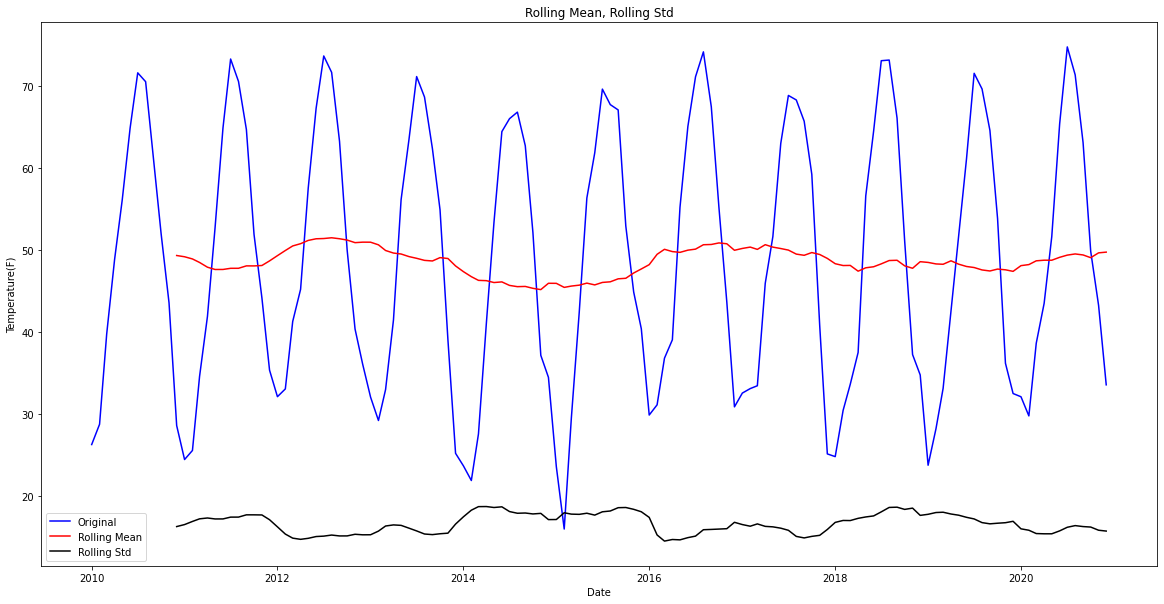

In [9]:
# Check whether it's stationary or not with Rolling Statistics

# Rolling Statistics
rolling_mean = wdata.rolling(window=12).mean()
rolling_std = wdata.rolling(window=12).std()

plt.figure(figsize=(20,10))
sns.lineplot(wdata['Date'],wdata['Temperature(F)'],color='blue',label='Original')
sns.lineplot(wdata['Date'],rolling_mean['Temperature(F)'],color='red',label='Rolling Mean')
sns.lineplot(wdata['Date'],rolling_std['Temperature(F)'],color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean, Rolling Std')



- **Seems to have a seasonality**

In [10]:
# Adfuller test
# H0 : It is Non-Stationary
# H1 : It is Stationary

adfuller_test(wdata['Temperature(F)'])

ADF Statistic: -2.066019257577948
p-value: 0.25839605124276527
Critical Values:
	1%: -3.485585145896754
	5%: -2.885738566292665
	10%: -2.5796759080663887


- As the p-value is higher than 0.05, can not reject Null Hypothesis(The dataset is not stationary)

- It is Non-Stationary Since It Has A Seasonality

### Convert the dataset to be stationary

In [11]:
# Make it Stationary by taking the differencing with the actual data and shifted data
wdata['Seasonality First Difference'] = wdata['Temperature(F)'].diff(12) # Subtracting previous 12 data

/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [12]:
adfuller_test(wdata['Seasonality First Difference'].dropna())

ADF Statistic: -2.685016305163188
p-value: 0.07666718538703125
Critical Values:
	1%: -3.492995948509562
	5%: -2.888954648057252
	10%: -2.58139291903223


- Slightly higher than 0.05 but still better than previous situation

<AxesSubplot:xlabel='Date', ylabel='Seasonality First Difference'>

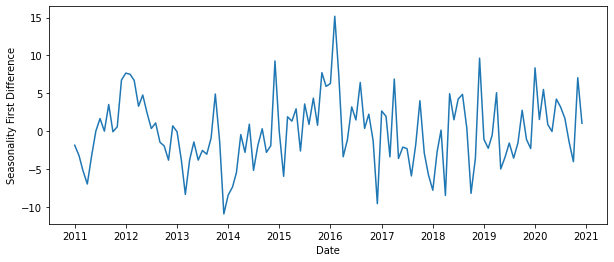

In [13]:
# Visualize Stationary Dataset
plt.figure(figsize=(10,4))
sns.lineplot(x=wdata['Date'],y=wdata['Seasonality First Difference'].dropna())

# ACF & PACF

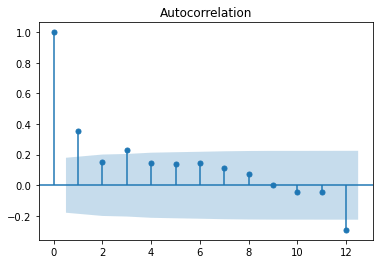

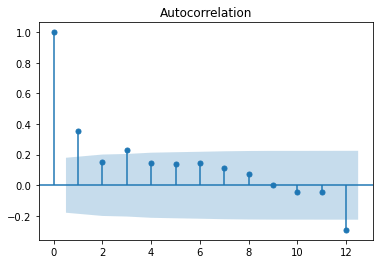

In [14]:
# plot_acf & plot_pacf
plot_acf(wdata['Seasonality First Difference'].iloc[13:],lags=12) 

- MA(2)

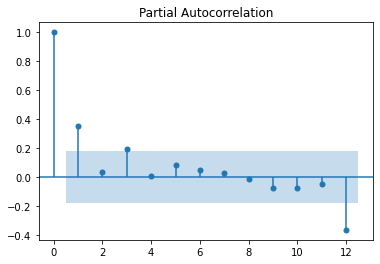

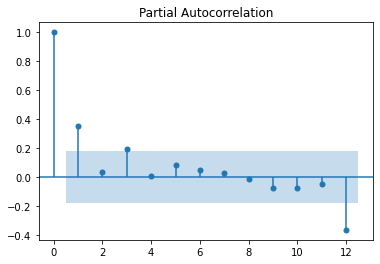

In [15]:
plot_pacf(wdata['Seasonality First Difference'].iloc[13:],lags=12) # p = 2

- AR(2)

# SARIMAX

In [16]:
# Fit the SARIMAX model
model = sm.tsa.statespace.SARIMAX(wdata['Temperature(F)'],order=(2,1,2),seasonal_order=(2,1,2,12)) 
results = model.fit()


/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
wdata['Forecast'] = results.predict(start=24,end=132,dynamic=True)

/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='Date'>

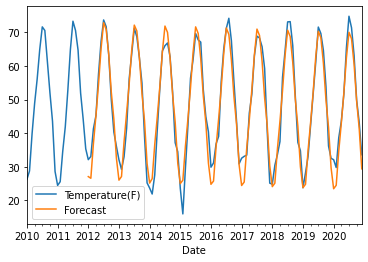

In [18]:
wdata = wdata.set_index('Date')
wdata[['Temperature(F)','Forecast']].plot()

In [19]:
wdata['Forecast'].iloc[23]

nan

In [20]:
# MAPE
print("The Mean Absolute Percent Errors : {:.6f}%".format(mean_absolute_percentage_error(wdata['Temperature(F)'].iloc[24:],wdata['Forecast'].iloc[24:])))

The Mean Absolute Percent Errors : 8.242096%


# Improving the SARIMAX model

In [21]:
p = range(0,3)
q = range(0,3)
d = range(1,2)

best_aic = np.inf
best_aic_order = tuple()
pdq = list(itertools.product(p,d,q))

for o in pdq:
    o_list = list(o)
    o_list.append(12)
    s_o = tuple(o_list)
    model = sm.tsa.statespace.SARIMAX(wdata['Temperature(F)'],order=o,seasonal_order=s_o)
    results = model.fit()
    if(results.aic < best_aic):
        best_aic = results.aic
        best_aic_order = o
print('The Best Order : {} with aic : {}'.format(best_aic_order,best_aic))

/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/daewoongjun/opt/anaconda3/lib/python3

The Best Order : (2, 1, 1) with aic : 642.713477978119


In [22]:
# Re-build the Model & Make Prediction again
model = sm.tsa.statespace.SARIMAX(wdata['Temperature(F)'],order=(2,1,1),seasonal_order=(2,1,1,12)) 
results = model.fit()
wdata['Forecast'] = results.predict(start=24,end=132,dynamic=True)

/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Date'>

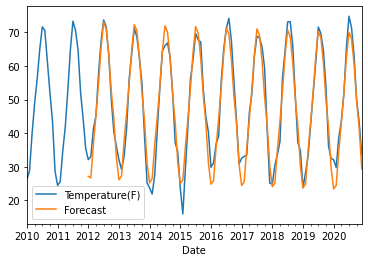

In [23]:
# Plot
wdata[['Temperature(F)','Forecast']].plot()

In [24]:
# Evaluate
print("The Mean Absolute Percent Errors : {:.6f}%".format(mean_absolute_percentage_error(wdata['Temperature(F)'].iloc[24:],wdata['Forecast'].iloc[24:])))

The Mean Absolute Percent Errors : 8.238169%


- The MAPE decreased a bit but still made an improvements!

# Testing the Model
- Use 2021 January - 2021 August data as the test sets

In [25]:
# Predicting 2021
ts = pd.Timestamp('2020-12-01')

test_sets = [ ts + DateOffset(months=i)for i in range(1,13)]
test_sets = pd.DataFrame(index=test_sets,columns=wdata.columns).reset_index() 


In [26]:
test_sets = test_sets.rename(columns={'index':'Date'})

In [27]:
test_sets = test_sets.set_index('Date')

In [28]:
test_sets = pd.concat([wdata,test_sets])

In [29]:
test_sets.tail(20)

,Temperature(F),Seasonality First Difference,Forecast
Date,,,
2020-05-01,51.631938,-0.019980,52.023670
2020-06-01,65.406356,4.254485,62.449636
2020-07-01,74.799252,3.223428,70.010195
2020-08-01,71.384170,1.718600,68.100866
2020-09-01,63.125677,-1.465349,60.495056
2020-10-01,49.844045,-3.997964,49.525791
2020-11-01,43.235975,7.066517,41.402839
2020-12-01,33.537082,1.062863,29.309533
2021-01-01,NaN,NaN,NaN


In [30]:
# Fit the model
model = sm.tsa.statespace.SARIMAX(test_sets['Temperature(F)'],order=(2,1,1),seasonal_order=(2,1,1,12)) 
results = model.fit()

/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [31]:
# Predict
test_sets['Forecast'] = results.predict(start=131,end=144,dynamic=True)

In [32]:
test_sets

,Temperature(F),Seasonality First Difference,Forecast
Date,,,
2010-01-01,26.243066,NaN,NaN
2010-02-01,28.719726,NaN,NaN
2010-03-01,39.739726,NaN,NaN
2010-04-01,48.830303,NaN,NaN
2010-05-01,56.096591,NaN,NaN
...,...,...,...
2021-08-01,NaN,NaN,70.465951
2021-09-01,NaN,NaN,64.745076
2021-10-01,NaN,NaN,53.362716


Text(0.5, 1.0, 'Predicted Temperature From 2021 Jan to 2021 Aug')

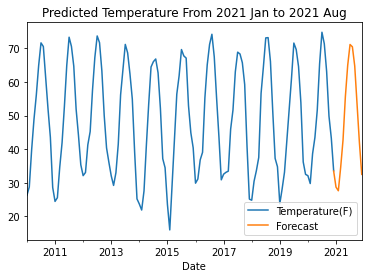

In [33]:
test_sets[['Temperature(F)','Forecast']].plot()
plt.title("Predicted Temperature From 2021 Jan to 2021 Aug")

# Metrics

In [34]:
forecast2021 = test_sets.loc["2021-01-01":"2021-08-01"]['Forecast']

In [35]:
forecast2021

Date
2021-01-01    28.684039
2021-02-01    27.590272
2021-03-01    34.595167
2021-04-01    42.694144
2021-05-01    55.583154
2021-06-01    64.952885
2021-07-01    71.148214
2021-08-01    70.465951
Name: Forecast, dtype: float64

In [36]:
# Now Lets See the Actual Dataset on 2021 Jan to Aug (From wundergrounds.com)
actualWeatherMean = [29.86,25.12,37.39,44.99,55.53,65.11,69.33,73.95]
dates = ["2021-01-01","2021-02-01","2021-03-01","2021-04-01","2021-05-01","2021-06-01","2021-07-01","2021-08-01"]
dates = pd.to_datetime(dates)
actualWeatherMean = pd.Series(actualWeatherMean)
actualWeatherMean.index = dates
actualWeatherMean.index.name = 'Date'

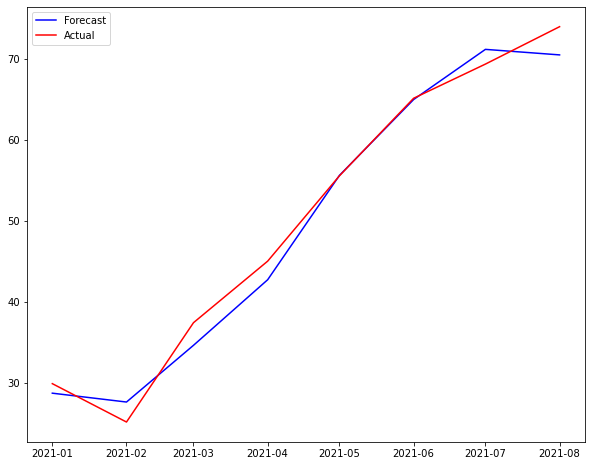

In [37]:
plt.figure(figsize=(10,8))
plt.plot(forecast2021,color="blue",label="Forecast")
plt.plot(actualWeatherMean,color="red",label="Actual")
plt.legend(loc="best")

In [38]:
pd.DataFrame({"Forecast":forecast2021,"Actual":actualWeatherMean,"Difference":actualWeatherMean-forecast2021})

,Forecast,Actual,Difference
Date,,,
2021-01-01,28.684039,29.86,1.175961
2021-02-01,27.590272,25.12,-2.470272
2021-03-01,34.595167,37.39,2.794833
2021-04-01,42.694144,44.99,2.295856
2021-05-01,55.583154,55.53,-0.053154
2021-06-01,64.952885,65.11,0.157115
2021-07-01,71.148214,69.33,-1.818214
2021-08-01,70.465951,73.95,3.484049


In [39]:
print("The Mean Absolute Percent Errors : {:.6f}%".format(mean_absolute_percentage_error(actualWeatherMean,forecast2021)))

The Mean Absolute Percent Errors : 4.252615%


# Therefore....
- In 2021, The temperature on each month in Toronto would expected to be like this :

In [40]:
# Predicting 2021 Jan to 2021 Aug

ts = pd.Timestamp('2020-12-01')

test_sets = [ ts + DateOffset(months=i)for i in range(1,13)]
test_sets = pd.DataFrame(index=test_sets,columns=wdata.columns).reset_index()

test_sets = test_sets.rename(columns={'index':'Date'})
test_sets = test_sets.set_index('Date')
test_sets = pd.concat([wdata,test_sets])

In [41]:
# Predict
model = sm.tsa.statespace.SARIMAX(test_sets['Temperature(F)'],order=(2,1,1),seasonal_order=(2,1,1,12)) 
results = model.fit()
test_sets['Forecast'] = results.predict(start=131,end=145,dynamic=True)

/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/daewoongjun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'Predicted Temperature of 2021')

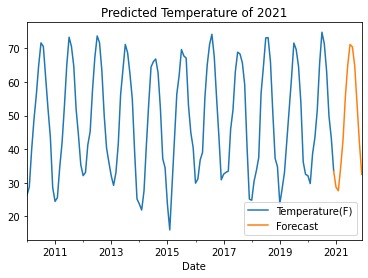

In [42]:
test_sets[['Temperature(F)','Forecast']].plot()
plt.title("Predicted Temperature of 2021")

Text(0.5, 1.0, '2021 Predicted Temperature on Each Month')

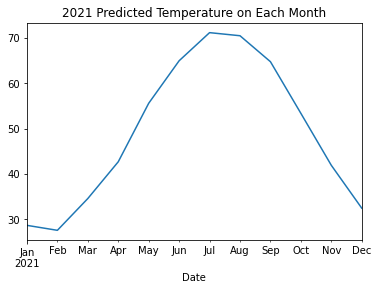

In [43]:
test_sets['Forecast'].iloc[132:].plot()
plt.title("2021 Predicted Temperature on Each Month")

In [44]:
# Done